# Understanding Seasonality

## 1] Helper Tools

In [1]:
import pandas as pd
import traceback
from datetime import timedelta

In [2]:
def merge_df(df_a, df_b, na='ffill', **kwargs):
	""" Merge data frames.
	"""
	try:
		# clean first
		dfa = df_a.copy()
		if 'date' not in dfa.columns:
			dfa = dfa.reset_index()
		dfa['date'] = pd.to_datetime(dfa['date'], format='%Y-%m-%d')
		# clean first
		dfb = df_b.copy()
		if 'date' not in dfb.columns:
			dfb = dfb.reset_index()
		dfb['date'] = pd.to_datetime(dfb['date'], format='%Y-%m-%d')
		# merge
		dfa = dfa.copy().set_index('date')
		dfb = dfb.copy().set_index('date')
		df = dfa.merge(dfb, **kwargs)
		# if DEBUG:
		# print('RLCOM: DEBUG: merge_df() | nan df=\n%s' % pd.isna(df.tail(10)))
		df = df.reset_index()
		df = df.sort_values(by='date').copy()
		if na == 'ffill':
			df = df.ffill()
		elif na == 'fillna0':
			df = df.fillna(0)
		elif 'drop' in na:
			df = df.dropna()
		return df.copy()
	except Exception as e:
		if isinstance(df_a, pd.core.frame.DataFrame) and isinstance(df_b, pd.core.frame.DataFrame):
			print(
				'WARNING Could not merge dataframe - \n' + str(df_a.tail(1)) +
				'\nwith dataframe - \n' + str(df_b.tail(1))
			)
		print(
			'ERROR: Exception for merge_df() ERR - \n' + str(traceback.format_exc()) +
			'\n' + str(e)
		)
		return df_a

def get_timeframe_by_dates(date_a, date_b, date_c):
	""" Determines the series period frequency by looking at their dates.
		 We use three dates just incase we start at a weekend.
		 INPUT: date from period 1, date from period 2, date from period 3
		 OUTPUT: monthly, quarterly, daily, weekly, annual
	"""
	a = pd.to_datetime(date_a).strftime('%Y-%m-%d')
	b = pd.to_datetime(date_b).strftime('%Y-%m-%d')
	c = pd.to_datetime(date_c).strftime('%Y-%m-%d')

	a_dt = pd.to_datetime(a)
	b_dt = pd.to_datetime(b)
	c_dt = pd.to_datetime(c)

	diff1 = abs(b_dt - a_dt)
	diff2 = abs(c_dt - b_dt)
	# print('get_timeframe_by_dates() | Difference = ' + str(diff))  # Debug
	two_weeks = timedelta(weeks=2)
	six_weeks = timedelta(weeks=6)
	one_day = timedelta(days=1)
	four_days = timedelta(days=4)
	eleven_days = timedelta(days=11)
	two_months = timedelta(weeks=8)
	four_months = timedelta(weeks=16)
	ten_months = timedelta(weeks=40)
	fourteen_months = timedelta(weeks=60)
	is_a_month = (
		(diff1 > two_weeks and diff1 < six_weeks) or (diff2 > two_weeks and diff2 < six_weeks)
	)
	is_a_quarter = (
		(diff1 > two_months and diff1 < four_months) or (diff2 > two_months and diff2 < four_months)
	)
	is_a_day = (diff1 == one_day) or (diff2 == one_day)
	is_a_week = (
		(diff1 > four_days and diff1 < eleven_days) or (diff2 > four_days and diff2 < eleven_days)
	)
	is_a_year = (
		(diff1 > ten_months and diff1 < fourteen_months) or
		(diff2 > ten_months and diff2 < fourteen_months)
	)
	if is_a_month:
		return 'monthly'
	elif is_a_quarter:
		return 'quarterly'
	elif is_a_day:
		return 'daily'
	elif is_a_week:
		return 'weekly'
	elif is_a_year:
		return 'yearly'
	else:
		return 'ERROR'

def add_quarterofyear_df(dfp):
	"""Calculates quarter of year and adds it to the input dataframe.
		INPUT: dataframe
		OUTPUT: enriched dataframe with quarter_of_year column
	"""
	df = dfp.copy()
	if 'date' not in df.columns:
		df = df.reset_index()
	df['date'] = pd.to_datetime(df['date'])
	df = df.set_index('date')
	df['quarter_of_year'] = pd.to_numeric(df.index.month / 3)
	df['quarter_of_year'] = df['quarter_of_year'].apply(
		lambda x: math.ceil(x)
	)
	return df.reset_index()


def add_monthofyear_df(dfp):
	"""Calculates month of year and adds it to the input dataframe.
		INPUT: dataframe
		OUTPUT: enriched dataframe with month_of_year column
	"""
	df = dfp.copy()
	if 'date' not in df.columns:
		df = df.reset_index()
	df['date'] = pd.to_datetime(df['date'])
	df['month_of_year'] = df['date'].apply(lambda x: x.month)
	return df


def add_dayofweek_df(dfp):
	"""Calculate day of week.
		INPUT: dataframe
		OUTPUT: enriched dataframe with day_of_week column Monday0 to Sunday6
	"""
	df = dfp.copy()
	if 'date' not in df.columns:
		df = df.reset_index()
	df['date'] = pd.to_datetime(df['date'])
	df['day_of_week'] = df['date'].apply(lambda x: x.dayofweek)
	return df


def add_weekofmonth_df(dfp):
	"""Calculate week of month.
		INPUT: dataframe
		OUTPUT: enriched dataframe with week_of_month column
	"""
	df = dfp.copy()
	if 'date' not in df.columns:
		df = df.reset_index()
	df['date'] = pd.to_datetime(df['date'])
	df = df.set_index('date')
	df['week_of_month'] = pd.to_numeric(df.index.day / 7)
	df['week_of_month'] = df['week_of_month'].apply(
		lambda x: math.ceil(x)
	)
	return df.reset_index()


In [3]:
def seasonality_row(value_list_df, time_frame):
	"""A helper method for get_seasonality function.
	"""
	df = value_list_df.copy()
	is_daily = (time_frame == 'daily')
	is_weekly = (time_frame == 'weekly')
	is_monthly = (time_frame == 'monthly')
	is_quarterly = (time_frame == 'quarterly')
	season_key = ''
	if is_daily:
		df = add_dayofweek_df(df)
		season_key = 'day_of_week'
	elif is_weekly:
		df = add_weekofmonth_df(df)
		season_key = 'week_of_month'
	elif is_monthly:
		df = add_monthofyear_df(df)
		season_key = 'month_of_year'
	elif is_quarterly:
		df = add_quarterofyear_df(df)
		season_key = 'quarter_of_year'
	else:
		print('Invalid time frame of ' + str(time_frame))
	df = df.reset_index()
	enriched = []
	for index, row in df.iterrows():
		date = row['date']
		if 'close' in row:
			open_val = row['open']
			high_val = row['high']
			low_val = row['low']
			close_val = row['close']
		elif 'value' in row:
			close_val = row['value']
		season_value = row[season_key]
		if 'close' in row:
			enriched.append(
				{
					'date': date,
					season_key: season_value,
					'open': open_val,
					'high': high_val,
					'low': low_val,
					'close': close_val
				}
			)
		elif 'value' in row:
			enriched.append(
				{
					'date': date,
					season_key: season_value,
					'value': close_val
				}
			)
	return pd.DataFrame(enriched)


def get_seasonality_calcs_tag(x):
	v = x[0]
	insig_pct = x[1]
	if v > insig_pct:
		return 1
	elif v < (abs(insig_pct) * -1):
		return -1
	elif v <= insig_pct and v >= (abs(insig_pct) * -1):
		return 0


def get_seasonality_calcs(
	skeys, growth_rate_df, season_key, seasonality_base_data_point,
	window_periods, insig_pct=None, method='avg'
):
	"""A helper method for get_seasonality function.
	"""
	c = 0
	if 'mondays' in skeys:
		c = -1
	new_skey = ['date']
	for k in skeys:
		if k != 'date':
			c = c + 1
			if method == 'avg':
				growth_rate_df[k] = growth_rate_df[
					growth_rate_df[season_key] == c
				][seasonality_base_data_point].rolling(window_periods).mean()
			elif method == 'count':
				bull_k = '%s_bullc' % (k, )
				bear_k = '%s_bearc' % (k, )
				insig_k = '%s_insigc' % (k, )
				new_skey.extend([bull_k, bear_k, insig_k])
				# count rises
				result = []
				for i in range(0, growth_rate_df['date'].count()):
					window = growth_rate_df.iloc[i - window_periods:i]
					if window['date'].count() == window_periods:
						rise_count = window[(
							window[season_key] == c
						) & (
							window[seasonality_base_data_point] > insig_pct
						)][seasonality_base_data_point].count()
						result.append({'date': window['date'].tail(1).values[0], bull_k: rise_count})
					else:
						result.append({})
				df_counts = pd.DataFrame(result)
				growth_rate_df = pd.merge(growth_rate_df, df_counts, on='date')
				# count falls
				result = []
				for i in range(0, growth_rate_df['date'].count()):
					window = growth_rate_df.iloc[i - window_periods:i]
					if window['date'].count() == window_periods:
						fall_count = window[(
							window[season_key] == c
						) & (
							window[seasonality_base_data_point] < (abs(insig_pct) * -1.0)
						)][seasonality_base_data_point].count()
						result.append({'date': window['date'].tail(1).values[0], bear_k: fall_count})
					else:
						result.append({})
				df_counts = pd.DataFrame(result)
				growth_rate_df = pd.merge(growth_rate_df, df_counts, on='date')
				# count insignificants
				result = []
				for i in range(0, growth_rate_df['date'].count()):
					window = growth_rate_df.iloc[i - window_periods:i]
					if window['date'].count() == window_periods:
						insig_count = window[(
							window[season_key] == c
						) & (
							window[seasonality_base_data_point] <= insig_pct
						) & (
							window[seasonality_base_data_point] >= (abs(insig_pct) * -1.0)
						)][seasonality_base_data_point].count()
						result.append({'date': window['date'].tail(1).values[0], insig_k: insig_count})
					else:
						result.append({})
				df_counts = pd.DataFrame(result)
				growth_rate_df = pd.merge(growth_rate_df, df_counts, on='date')
			elif method == 'tag':
				growth_rate_df[k] = growth_rate_df[
					growth_rate_df[season_key] == c
				][seasonality_base_data_point].apply(
					lambda x: get_seasonality_calcs_tag((x, insig_pct))
				)
			else:
				print('ERROR: No correct method found.')
				sys.exit(1)
	if new_skey.__len__() > 1:
		if method == 'tag':
			# Do not mess up the tagged probability space
			seasonality_df = growth_rate_df[new_skey]
		else:
			seasonality_df = growth_rate_df[new_skey].ffill()
		skeys = new_skey
	else:
		if method == 'tag':
			seasonality_df = growth_rate_df[skeys]
		else:
			seasonality_df = growth_rate_df[skeys].ffill()
	return skeys, seasonality_df


def get_seasonality(window_periods, df, insig_pct=None, method='avg', **kwargs):
	"""Calculates seasonality based on window period growth rate.
		The seasonality value is the rolling average seasonality of that frequency group.
		INPUT: window_periods, dataframe - OHLC or value column data frame
													- all data will be converted to a growth rate
				 insig_pct - Configure this to return a count of bears and bulls
							  - use insig_pct to exclude growth rates that are too small
							  - example - insig_pct=0.05 - 5 percent gr will be counted as too small
		OUTPUT: dataframe with seasonality columns
				  - For normal seasonality returning average growth rate per seasonal period
						** we return a pattern of columns as per below
						- mondays, tuesdays etc. for daily time frames
						- week_1, week_2 etc. for weekly time frames
						- month_1, month_2 etc. for monthly time frames
						- quarter_1, quarter_2 etc. for quarterly time frames
				  - For bear, bull, insig counts for odds calcs per seasonal period
						** we return a pattern of columns as per below
						- mondays_bearc, mondays_bullc, mondays_insigc etc. for daily time frames
						- week_1_bearc, week_2_bearc etc. for weekly time frames
						- month_1_bullc, month_2_bullc etc. for monthly time frames
						- quarter_1_insigc, quarter_2_insigc etc. for quarterly time frames
	"""
	value_list_df = df.copy()
	if value_list_df.empty or value_list_df['date'].count() < 4:
		return pd.DataFrame()
	# is_ohlc = ('close' in value_list_df.columns)
	# is_econometric = ('value' in value_list_df.columns)
	value_list_df['date'] = pd.to_datetime(value_list_df['date'])
	value_list_df = value_list_df.sort_values(by='date')
	if 'gr' not in value_list_df.columns:
		value_list_df = get_growth_rate(value_list_df)
	value_list_df['value'] = value_list_df['gr']
	value_list_df = value_list_df[['date', 'value']].copy()
	date_a = value_list_df['date'].iloc[3]
	date_b = value_list_df['date'].iloc[4]
	date_c = value_list_df['date'].iloc[5]

	time_frame = get_timeframe_by_dates(date_a, date_b, date_c)
	is_daily = (time_frame == 'daily')
	is_weekly = (time_frame == 'weekly')
	is_monthly = (time_frame == 'monthly')
	is_quarterly = (time_frame == 'quarterly')
	# is_annual = (time_frame == 'annual')
	season_key = ''
	if is_daily:
		grouped_seasonality = [
			seasonality_row(g, time_frame) for n, g in value_list_df.set_index(
				'date'
			).groupby(
				pd.Grouper(freq='W')
			)
		]
		season_key = 'day_of_week'
	elif is_weekly:
		grouped_seasonality = [
			seasonality_row(g, time_frame) for n, g in value_list_df.set_index(
				'date'
			).groupby(
				pd.Grouper(freq='Y')
			)
		]
		season_key = 'week_of_month'
	elif is_monthly:
		grouped_seasonality = [
			seasonality_row(g, time_frame) for n, g in value_list_df.set_index(
				'date'
			).groupby(
				pd.Grouper(freq='Y')
			)
		]
		season_key = 'month_of_year'
	elif is_quarterly:
		grouped_seasonality = [
			seasonality_row(g, time_frame) for n, g in value_list_df.set_index(
				'date'
			).groupby(
				pd.Grouper(freq='Y')
			)
		]
		season_key = 'quarter_of_year'
	else:
		print(
			'WARNING: get_seasonality() - Could not detect window time frame - result - ' +
			str(time_frame)
		)
		return []
	metric_list = []
	seasonality_base_data_point = ''
	for group in grouped_seasonality:
		for index, row in group.iterrows():
			metric_list.append(
				{
					'date': row['date'],
					season_key: row[season_key],
					'value': float(row['value'])
				}
			)
	growth_rate_df = pd.DataFrame(metric_list)
	# print(
	#    'growth_rate_df 4 samples: ' + str(growth_rate_df[:4])
	# )
	keys_daily = [
		'date', 'mondays', 'tuesdays', 'wednesdays', 'thursdays', 'fridays', 'saturdays', 'sundays'
	]
	keys_weekly = ['date']
	keys_weekly.extend(['week_%s' % (x, ) for x in range(1, 6)])
	keys_monthly = ['date']
	keys_monthly.extend(['month_%s' % (x, ) for x in range(1, 13)])
	keys_quarterly = ['date']
	keys_quarterly.extend(['quarter_%s' % (x, ) for x in range(1, 5)])
	seasonality_base_data_point = 'value'
	seasonality_option_keys = []
	if is_daily:
		skeys = keys_daily
		skeys, seasonality_df = get_seasonality_calcs(
			skeys, growth_rate_df, season_key, seasonality_base_data_point,
			window_periods, insig_pct=insig_pct, method=method
		)
		seasonality_df = add_dayofweek_df(seasonality_df)
		seasonality_option_keys = ['date', 'day_of_week']
	elif is_weekly:
		skeys = keys_weekly
		skeys, seasonality_df = get_seasonality_calcs(
			skeys, growth_rate_df, season_key, seasonality_base_data_point,
			window_periods, insig_pct=insig_pct, method=method
		)
		seasonality_df = add_weekofmonth_df(seasonality_df)
		seasonality_option_keys = ['date', 'week_of_month']
	elif is_monthly:
		skeys = keys_monthly
		skeys, seasonality_df = get_seasonality_calcs(
			skeys, growth_rate_df, season_key, seasonality_base_data_point,
			window_periods, insig_pct=insig_pct, method=method
		)
		seasonality_df = add_monthofyear_df(seasonality_df)
		seasonality_option_keys = ['date', 'month_of_year']
	elif is_quarterly:
		skeys = keys_quarterly
		skeys, seasonality_df = get_seasonality_calcs(
			skeys, growth_rate_df, season_key, seasonality_base_data_point,
			window_periods, insig_pct=insig_pct, method=method
		)
		seasonality_df = add_quarterofyear_df(seasonality_df)
		seasonality_option_keys = ['date', 'quarter_of_year']
	for row in list(kwargs.keys()):
		if kwargs[row] is True:
			if row not in seasonality_option_keys:
				seasonality_option_keys.append(row)
	if seasonality_option_keys.__len__() == 2:
		for k in skeys:
			if k not in seasonality_option_keys:
				seasonality_option_keys.append(k)
	df = seasonality_df[seasonality_option_keys].reset_index().copy()
	del df['index']
	return df

In [4]:
def clean_col_helper(v):
    x = v
    if type(x) == str:
        x = x.replace(",", "")
        if x != '':
            return float(x)
        else:
            return np.nan

def clean_value_df_cols(df_in, col):
    df = df_in.copy()
    df = df.dropna()
    df[col] = df[col].apply(lambda x: clean_col_helper(x))
    df = df.dropna()
    df[col] = df[col].astype(float)
    return df

,date,close
0,2024-03-04,5130.95
1,2024-03-01,5137.09
2,2024-02-29,5096.27
3,2024-02-28,5069.76
4,2024-02-27,5078.20
5,2024-02-26,5069.53
6,2024-02-23,5088.80
7,2024-02-22,5087.03
8,2024-02-21,4981.80
9,2024-02-20,4975.51


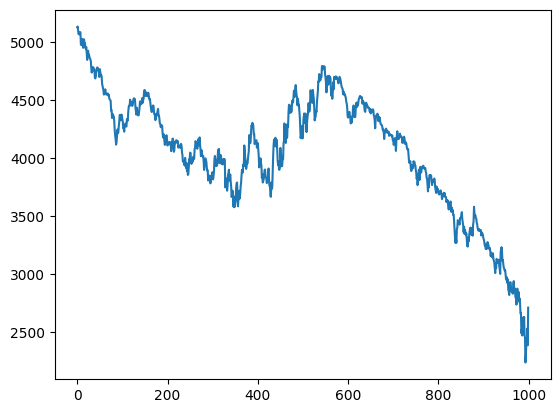

In [5]:
import pandas as pd
import numpy as np
# CSV from investing dot com
df = pd.read_csv('db/S&P_500_Historical_Data.csv')
# Clean the data frame
del df['Vol.']
df['date'] = pd.to_datetime(df['Date'])
df = clean_value_df_cols(df, 'Price')
df['close'] = df['Price']
del df['Date']
del df['Price']
del df['Open']
del df['High']
del df['Low']
del df['Change %']
df.head(1000)['close'].plot()
df.head(10)

## 2] Breaking Down Seasonality Calculations For S&P500

<Axes: >

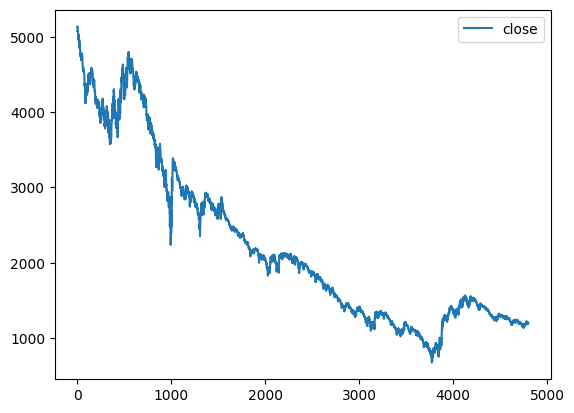

In [6]:
df = df.sort_values(by=['date'], ascending=True)
df['gr'] = df['close'].pct_change()
df
df[['close']].plot()

In [7]:
get_seasonality(30, df, insig_pct=0.00001, method='count').tail(60)

,date,day_of_week,mondays_bullc,mondays_bearc,mondays_insigc,tuesdays_bullc,tuesdays_bearc,tuesdays_insigc,wednesdays_bullc,wednesdays_bearc,...,thursdays_insigc,fridays_bullc,fridays_bearc,fridays_insigc,saturdays_bullc,saturdays_bearc,saturdays_insigc,sundays_bullc,sundays_bearc,sundays_insigc
4110,2023-11-06,0,5.0,1.0,0.0,3.0,3.0,0.0,4.0,2.0,...,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4111,2023-11-07,1,5.0,1.0,0.0,4.0,2.0,0.0,4.0,2.0,...,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4112,2023-11-08,2,5.0,1.0,0.0,4.0,2.0,0.0,4.0,2.0,...,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4113,2023-11-09,3,5.0,1.0,0.0,4.0,2.0,0.0,4.0,2.0,...,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4114,2023-11-10,4,5.0,1.0,0.0,4.0,2.0,0.0,4.0,2.0,...,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4115,2023-11-13,0,4.0,2.0,0.0,4.0,2.0,0.0,4.0,2.0,...,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4116,2023-11-14,1,4.0,2.0,0.0,5.0,1.0,0.0,4.0,2.0,...,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4117,2023-11-15,2,4.0,2.0,0.0,5.0,1.0,0.0,4.0,2.0,...,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4118,2023-11-16,3,4.0,2.0,0.0,5.0,1.0,0.0,4.0,2.0,...,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4119,2023-11-17,4,4.0,2.0,0.0,5.0,1.0,0.0,4.0,2.0,...,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
value_list_df = df
value_list_df['value'] = value_list_df['gr']
value_list_df = value_list_df[['date', 'value']].copy()
time_frame = 'daily'
grouped_seasonality = [
    seasonality_row(g, time_frame) for n, g in value_list_df.set_index(
        'date'
    ).groupby(
        pd.Grouper(freq='W')
    )
]
season_key = 'day_of_week'
grouped_seasonality[:4]

[        date  day_of_week     value
 0 2005-02-07            0       NaN
 1 2005-02-08            1  0.000499
 2 2005-02-09            2 -0.008567
 3 2005-02-10            3  0.004195
 4 2005-02-11            4  0.006934,
         date  day_of_week     value
 0 2005-02-14            0  0.000664
 1 2005-02-15            1  0.003316
 2 2005-02-16            2  0.000165
 3 2005-02-17            3 -0.007849
 4 2005-02-18            4  0.000666,
         date  day_of_week     value
 0 2005-02-22            1 -0.014481
 1 2005-02-23            2  0.005573
 2 2005-02-24            3  0.007894
 3 2005-02-25            4  0.009332,
         date  day_of_week     value
 0 2005-02-28            0 -0.006439
 1 2005-03-01            1  0.005650
 2 2005-03-02            2 -0.000248
 3 2005-03-03            3  0.000331
 4 2005-03-04            4  0.009583]

In [9]:
metric_list = []
seasonality_base_data_point = ''
for group in grouped_seasonality:
    for index, row in group.iterrows():
        metric_list.append(
            {
                'date': row['date'],
                season_key: row[season_key],
                'value': float(row['value'])
            }
        )
growth_rate_df = pd.DataFrame(metric_list)
# print(
#    'growth_rate_df 4 samples: ' + str(growth_rate_df[:4])
# )
keys_daily = [
    'date', 'mondays', 'tuesdays', 'wednesdays', 'thursdays', 'fridays', 'saturdays', 'sundays'
]
keys_weekly = ['date']
keys_weekly.extend(['week_%s' % (x, ) for x in range(1, 6)])
keys_monthly = ['date']
keys_monthly.extend(['month_%s' % (x, ) for x in range(1, 13)])
keys_quarterly = ['date']
keys_quarterly.extend(['quarter_%s' % (x, ) for x in range(1, 5)])
skeys = keys_daily
growth_rate_df.tail(30)

,date,day_of_week,value
4770,2024-01-22,0,0.002194
4771,2024-01-23,1,0.002921
4772,2024-01-24,2,0.000812
4773,2024-01-25,3,0.005260
4774,2024-01-26,4,-0.000652
4775,2024-01-29,0,0.007557
4776,2024-01-30,1,-0.000601
4777,2024-01-31,2,-0.015452
4778,2024-02-01,3,0.011821
4779,2024-02-02,4,0.010684


In [10]:
season_key = 'day_of_week'
seasonality_base_data_point = 'value'
insig_pct = 0.00001
window_periods = 60
c = 0
i = 4799
# count rises
result = []
for i in range(0, growth_rate_df['date'].count()):
    window = growth_rate_df.iloc[i - window_periods:i]
    if window['date'].count() == window_periods:
        rise_count = window[(
            window[season_key] == c
        ) & (
            window[seasonality_base_data_point] > insig_pct
        )][seasonality_base_data_point].count()
        result.append({'date': window['date'].tail(1).values[0], 'mondays_bullc': rise_count})
    else:
        result.append({})
df_test = pd.DataFrame(result)

In [11]:
pd.merge(growth_rate_df, df_test, on='date')

,date,day_of_week,value,mondays_bullc
0,2005-05-03,1,-0.000860,8.0
1,2005-05-04,2,0.012487,8.0
2,2005-05-05,3,-0.002637,8.0
3,2005-05-06,4,-0.001109,8.0
4,2005-05-09,0,0.006403,9.0
...,...,...,...,...
4735,2024-02-26,0,-0.003787,5.0
4736,2024-02-27,1,0.001710,5.0
4737,2024-02-28,2,-0.001662,5.0
4738,2024-02-29,3,0.005229,5.0


In [12]:
season_key = 'day_of_week'
seasonality_base_data_point = 'value'
insig_pct = 0.001
window_periods = 14
c = 0
if 'mondays' in skeys:
    c = -1
new_skey = ['date']
for k in skeys:
    if k != 'date':
        c = c + 1
        bull_k = '%s_bullc' % (k, )
        bear_k = '%s_bearc' % (k, )
        insig_k = '%s_insigc' % (k, )
        new_skey.extend([bull_k, bear_k, insig_k])
        # count rises
        result = []
        for i in range(0, growth_rate_df['date'].count()):
            window = growth_rate_df.iloc[i - window_periods:i]
            if window['date'].count() == window_periods:
                rise_count = window[(
                    window[season_key] == c
                ) & (
                    window[seasonality_base_data_point] > insig_pct
                )][seasonality_base_data_point].count()
                result.append({'date': window['date'].tail(1).values[0], bull_k: rise_count})
            else:
                result.append({})
        df_counts = pd.DataFrame(result)
        growth_rate_df = pd.merge(growth_rate_df, df_counts, on='date')
        # count falls
        result = []
        for i in range(0, growth_rate_df['date'].count()):
            window = growth_rate_df.iloc[i - window_periods:i]
            if window['date'].count() == window_periods:
                fall_count = window[(
                    window[season_key] == c
                ) & (
                    window[seasonality_base_data_point] < (abs(insig_pct) * -1.0)
                )][seasonality_base_data_point].count()
                result.append({'date': window['date'].tail(1).values[0], bear_k: fall_count})
            else:
                result.append({})
        df_counts = pd.DataFrame(result)
        growth_rate_df = pd.merge(growth_rate_df, df_counts, on='date')
        # count insignificants
        result = []
        for i in range(0, growth_rate_df['date'].count()):
            window = growth_rate_df.iloc[i - window_periods:i]
            if window['date'].count() == window_periods:
                insig_count = window[(
                    window[season_key] == c
                ) & (
                    window[seasonality_base_data_point] <= insig_pct
                ) & (
                    window[seasonality_base_data_point] >= (abs(insig_pct) * -1.0)
                )][seasonality_base_data_point].count()
                result.append({'date': window['date'].tail(1).values[0], insig_k: insig_count})
            else:
                result.append({})
        df_counts = pd.DataFrame(result)
        growth_rate_df = pd.merge(growth_rate_df, df_counts, on='date')

pd.options.display.max_columns = 30
seasonality_df = growth_rate_df 
seasonality_df.tail(20)

,date,day_of_week,value,mondays_bullc,mondays_bearc,mondays_insigc,tuesdays_bullc,tuesdays_bearc,tuesdays_insigc,wednesdays_bullc,...,thursdays_insigc,fridays_bullc,fridays_bearc,fridays_insigc,saturdays_bullc,saturdays_bearc,saturdays_insigc,sundays_bullc,sundays_bearc,sundays_insigc
4486,2024-01-04,3,-0.003428,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4487,2024-01-05,4,0.001826,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4488,2024-01-08,0,0.014115,2.0,0.0,0.0,2.0,1.0,0.0,1.0,...,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4489,2024-01-09,1,-0.001478,1.0,0.0,0.0,2.0,2.0,0.0,1.0,...,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4490,2024-01-10,2,0.005666,1.0,0.0,0.0,1.0,2.0,0.0,2.0,...,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4491,2024-01-11,3,-0.000671,1.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4492,2024-01-12,4,0.000751,1.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4493,2024-01-16,1,-0.004386,1.0,0.0,0.0,1.0,3.0,0.0,2.0,...,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4494,2024-01-17,2,-0.004963,1.0,0.0,0.0,0.0,3.0,0.0,2.0,...,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4495,2024-01-18,3,0.008805,1.0,0.0,0.0,0.0,3.0,0.0,1.0,...,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


By using a small seasonal window, we can count the odds on monday and check if the code is working. We can see 2 bulls in the last t

## 3] Conclusion

In [13]:
window_periods = 60
df = get_seasonality(window_periods, df, insig_pct=0.0001, method='count')
pd.options.display.max_columns = 30
df.tail(30)

,date,day_of_week,mondays_bullc,mondays_bearc,mondays_insigc,tuesdays_bullc,tuesdays_bearc,tuesdays_insigc,wednesdays_bullc,wednesdays_bearc,...,thursdays_insigc,fridays_bullc,fridays_bearc,fridays_insigc,saturdays_bullc,saturdays_bearc,saturdays_insigc,sundays_bullc,sundays_bearc,sundays_insigc
3510,2023-12-19,1,7.0,4.0,1.0,8.0,4.0,1.0,8.0,4.0,...,0.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3511,2023-12-20,2,7.0,4.0,1.0,8.0,3.0,1.0,8.0,5.0,...,0.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3512,2023-12-21,3,7.0,4.0,1.0,8.0,3.0,1.0,7.0,5.0,...,0.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3513,2023-12-22,4,7.0,4.0,1.0,8.0,3.0,1.0,7.0,5.0,...,0.0,8.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3514,2023-12-26,1,7.0,4.0,1.0,9.0,3.0,1.0,7.0,5.0,...,0.0,8.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3515,2023-12-27,2,7.0,4.0,0.0,9.0,3.0,1.0,8.0,5.0,...,0.0,8.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3516,2023-12-28,3,7.0,4.0,0.0,9.0,2.0,1.0,8.0,5.0,...,0.0,8.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3517,2023-12-29,4,7.0,4.0,0.0,9.0,2.0,1.0,7.0,5.0,...,0.0,8.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3518,2024-01-02,1,7.0,4.0,0.0,9.0,3.0,1.0,7.0,5.0,...,0.0,8.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3519,2024-01-03,2,7.0,4.0,0.0,9.0,3.0,1.0,7.0,6.0,...,0.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


For now we should use the main method get_seasonality() to get an enrichment of data.

For the past two months we can see there is a strong seasonal bull on a monday with an odds of 7:3. This is almost double the chances of random.

The seasonal odds on a tuesday is 7:6 which is nearly 1:1. We should not do anything on this day.

Based on counting odds, we should buy on fridays, and sell on tuesdays to maximize returns.

We broke down seasonal odds calculations on a daily basis. Through experimentation we proved that it is counting correctly. This notebook is just for resume purposes. Copy code and errors at your own risk. If this is important to you, hire me! I'm sure i can adapt this to your needs and have it well tested.